In [20]:
import torch
import numpy as np
from os import walk
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [22]:
# dataset is here: smb://nas-weber01.unisg.ch/data/Nassy/03_Online_Model/features
_, _, file_names = next(walk('./dataset'))

files = [(name.split('_')[0], name.split('_')[1].split('.')[0], name) for name in file_names]

dataset = pd.DataFrame()

for (subject_number, task, file_name) in files:
    part = pd.read_csv(f'./dataset/{file_name}')
    labels = pd.read_csv(f'./labels/{subject_number}.csv', sep=";").set_index('task')
    rating = float(labels.loc[task]['r'])
    part['label'] = int(rating > 4)
    part['subject'] = subject_number
    part['d_lhipa'] = part['e_lhipa'] - part['b_lhipa']
    part['d_peak_count'] = part['e_peak_count'] - part['b_peak_count']
    part['d_median'] = part['e_median'] - part['b_median']
    part['d_std'] = part['e_std'] - part['b_std']
    part['d_mean'] = part['e_mean'] - part['b_mean']

    dataset = pd.concat([part, dataset])

print(len(dataset[dataset['label'] == 1]), len(dataset[dataset['label'] == 0]))
    
dataset.tail(80)

16 48


,task,subject,d_mean,d_median,d_std,e_min,e_max,e_mean,e_median,e_std,e_peak_count,e_peak_count_pm,b_min,b_max,b_mean,b_median,b_std,b_peak_count,b_peak_count_pm,e_lhipa,b_lhipa,label,d_lhipa,d_peak_count
0,t2,003,-0.501619,-0.518017,-0.112622,2.241898,3.114388,2.651506,2.651398,0.109360,0,NaN,2.310593,3.708145,3.153125,3.169415,0.221982,0,NaN,13.3,11.0,0,2.3,0
0,t8,001,-0.945959,-0.985149,-0.102999,2.890831,4.984642,3.671068,3.634178,0.216519,0,NaN,3.994537,5.087128,4.617027,4.619328,0.319517,0,NaN,28.1,0.0,0,28.1,0
0,t5,003,-0.537380,-0.564941,-0.025603,2.307175,3.327171,2.711090,2.682655,0.153464,0,NaN,2.217499,3.706642,3.248470,3.247597,0.179067,0,NaN,12.8,15.5,0,-2.7,0
0,t3,005,-0.752089,-0.773006,-0.088727,2.961998,4.656769,3.523036,3.493267,0.186262,0,NaN,3.181503,5.344917,4.275126,4.266273,0.274989,0,NaN,5.1,16.4,0,-11.3,0
0,t2,008,-1.109246,-1.105423,-0.204236,2.687057,5.440842,3.246545,3.218582,0.212706,0,NaN,3.374695,5.771500,4.355791,4.324005,0.416942,0,NaN,11.0,17.3,1,-6.3,0
0,t5,001,-0.232652,-0.221928,-0.004048,2.727715,5.748344,4.018117,3.995552,0.278534,0,NaN,3.911629,5.052734,4.250769,4.217480,0.282582,0,NaN,20.6,0.0,0,20.6,0
0,t7,008,-1.007367,-0.947262,-0.216214,2.720512,4.512596,3.278859,3.268639,0.205454,0,NaN,2.956421,5.823418,4.286225,4.215900,0.421668,0,NaN,15.3,17.3,1,-2.0,0
0,t5,002,-0.632371,-0.598808,-0.201099,2.681503,4.082291,3.101508,3.101326,0.148913,0,NaN,2.743629,4.754242,3.733879,3.700134,0.350012,0,NaN,11.1,12.7,1,-1.6,0
0,t7,005,-0.920647,-0.923412,-0.094265,2.290718,4.118576,3.198406,3.199776,0.227961,0,NaN,3.131569,5.158997,4.119053,4.123188,0.322226,0,NaN,10.6,15.8,0,-5.2,0
0,t3,003,-0.566063,-0.571507,-0.056880,2.255852,3.346382,2.634804,2.630943,0.117476,0,NaN,2.543549,3.982620,3.200867,3.202450,0.174356,0,NaN,8.0,10.0,0,-2.0,0


In [23]:
## create model
class NN(torch.nn.Module):
    def __init__(self, input_dimension,number_of_target_classes):
        super().__init__()
        # stack layers
        self.module_list = torch.nn.ModuleList()
        ## stacks contain of linear + nonlinear layers
        self.module_list.append(torch.nn.Linear(input_dimension,1200))
        self.module_list.append(torch.nn.Tanh())
        #
        self.module_list.append(torch.nn.Linear(1200,10))
        self.module_list.append(torch.nn.Tanh())

        # map to output layer
        self.module_list.append(torch.nn.Linear(10,number_of_target_classes))
    
    def forward(self,x):
        for module in self.module_list:
            x = module(x)
        return x

def train(dataset, task=None, subject=None):
    if not task:
        TRAIN_FILTER = (~(dataset['subject'] == subject))
    elif not subject:
        TRAIN_FILTER = (~(dataset['task'] == task))
    else:
        TRAIN_FILTER = (~(dataset['task'] == task) & ~(dataset['subject'] == subject))

    #fields = ['d_mean', 'd_median', 'd_std', 'e_min', 'e_max', 'e_mean', 'e_median', 'e_std', 'e_peak_count', 'e_peak_count_pm', 'b_min', 'b_max', 'b_mean', 'b_median', 'b_std', 'b_peak_count', 'b_peak_count_pm', 'e_lhipa', 'b_lhipa', 'd_lhipa', 'd_peak_count']
    fields = ['d_mean', 'd_median', 'd_std', 'd_lhipa', 'e_lhipa', 'd_peak_count']
    #print(list(dataset))
    data_train = dataset[~TRAIN_FILTER].drop(['subject', 'task', 'label'], axis=1)[fields].to_numpy()
    data_test = dataset[TRAIN_FILTER].drop(['subject', 'task', 'label'], axis=1)[fields].to_numpy()

    #[['e_lhipa','d_lhipa', 'd_peak_count', 'd_mean', 'd_median','d_std']]

    targets_train = dataset[~TRAIN_FILTER]['label'].to_numpy()
    targets_test = dataset[TRAIN_FILTER]['label'].to_numpy()


    ## wrap data in dataset
    # cast to tensor
    data_train = torch.tensor(data_train).float()
    targets_train = torch.tensor(targets_train).long()#.unsqueeze(dim=-1)
    data_test = torch.tensor(data_test).float()
    targets_test = torch.tensor(targets_test).long()#.unsqueeze(dim=-1)
    # wrap in dataset class
    dataset_train = torch.utils.data.TensorDataset(data_train, targets_train)
    dataset_test = torch.utils.data.TensorDataset(data_test, targets_test)
    # create dataloaders
    trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=10,shuffle=True)
    testloader = torch.utils.data.DataLoader(dataset_test, batch_size=10,shuffle=True)

    #instanciate model
    model = NN(len(fields),2)
    #model.to(device)
    # test forward pass
    model(data_train[:10])

    # def criterion and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.01)

    # train
    for epoch in range(3000):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, targets = data
            inputs.to(device)
            targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            # 
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 50 == 0:    # print every 2000 mini-batches
                #print("Training loss {} Steps: {}".format(running_loss / 1000, epoch * len(trainloader) + i))
                running_loss = 0.0

    y_pred = []
    y_true = []

    # iterate over test data
    for inputs, labels in testloader:
            output = model(inputs) # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

    # constant for classes
    classes = ('LOW', 'HIGH')
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    """
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes], columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)

    if not task:
        plt.savefig(f'without-subject-{subject}.png')
    elif not subject:
        plt.savefig(f'without-task-{task}.png')
    else:
        plt.savefig(f'without-task-{task}-subject-{subject}.png')
    """
    return cf_matrix

In [24]:
import itertools
subjects = [None]#list(set([subject_number for (subject_number, task, file_name) in files]))
tasks = list(set([task for (subject_number, task, file_name) in files])) 
permutation = list(itertools.product(tasks, subjects))

In [25]:
results = []
for task, subject in permutation:
    if task or subject:
        #results.append(train(dataset=dataset[(~(dataset['subject'] == '002'))], task=task, subject=subject))
        results.append(train(dataset=dataset, task=task, subject=subject))

print(results)

KeyboardInterrupt: 

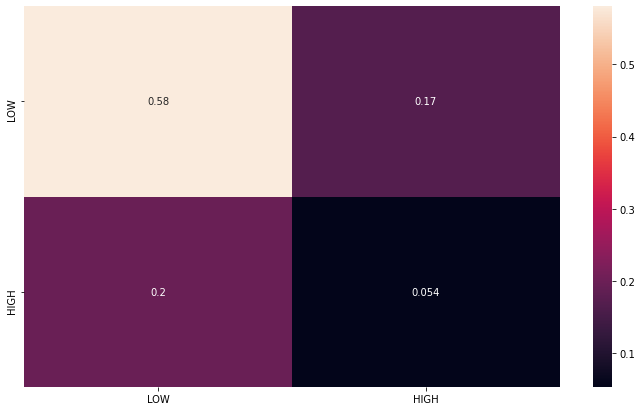

In [18]:
confusion_matrices = np.mean(results, axis=(0))
classes = ('LOW', 'HIGH')
df_cm = pd.DataFrame(confusion_matrices/np.sum(confusion_matrices), index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig(f'without-task-median.png')

In [19]:
57

57